In [1]:
!pip install dionysus
!pip install gudhi
!pip install alphashape
!pip install zarr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dionysus: filename=dionysus-2.0.10-cp310-cp310-linux_x86_64.whl size=440653 sha256=f8e598dcc2c128ef562e424361a02b36fbc9b790f94de7d6ced04b379d2e7aeb
  Stored in directory: /root/.cache/pip/wheels/1d/8f/2a/22f69fac8dab81069f0501bdd69961a69e82b8b3007f191a15
Successfully built dionysus
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.5/682.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.1/206.1 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 17.1 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=e93395e460c23e7ba3d2e7f0c2831fe3ede2166fe872977f

In [2]:
import numpy as np
import dionysus as d
import matplotlib.pyplot as plt
import networkx as nx
import scipy.spatial as sp
import zarr
import alphashape
from shapely.geometry import Polygon, mapping
import zarr

In [3]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive',force_remount=True)

import os
os.chdir("/content/drive/My Drive/NASA/Fire Detection")
!ls -ltr

Mounted at /content/drive
total 12
drwx------ 2 root root 4096 Jun  6 00:50 'zzpd fire data'
drwx------ 2 root root 4096 Jun  9 01:01 'zzpd fire data 2'
drwx------ 2 root root 4096 Jul  6 01:45 'zzpd fire data 3'


In [4]:
#fname = 'zzpd fire data 2' # old dataset
fname = 'zzpd fire data 3'
rawFileList = os.listdir(fname)
print (rawFileList)
print (len(rawFileList))

['Tile_1_33_20201501711176.zarr', 'Tile_1_33_20201501801176.zarr', 'Tile_1_33_20201511406176.zarr', 'Tile_1_33_20201501811176.zarr', 'Tile_1_33_20201501701176.zarr', 'Tile_1_33_20201501756176.zarr', 'Tile_1_33_20201511436176.zarr', 'Tile_1_33_20201511416176.zarr', 'Tile_1_33_20201491716176.zarr']
9


In [5]:
channel7List = []
channel7Name = []
timeSeriesDict = {}

rawFileList = sorted(rawFileList)[0:8]

for name in rawFileList:
    channelData = np.array(zarr.open(fname + '//' + name)[:, :, 0]) # select channel 7
    timeSeriesDict[name] = channelData
    channel7List.append(channelData)
    channel7Name.append(name)

print (len(channel7List))

8


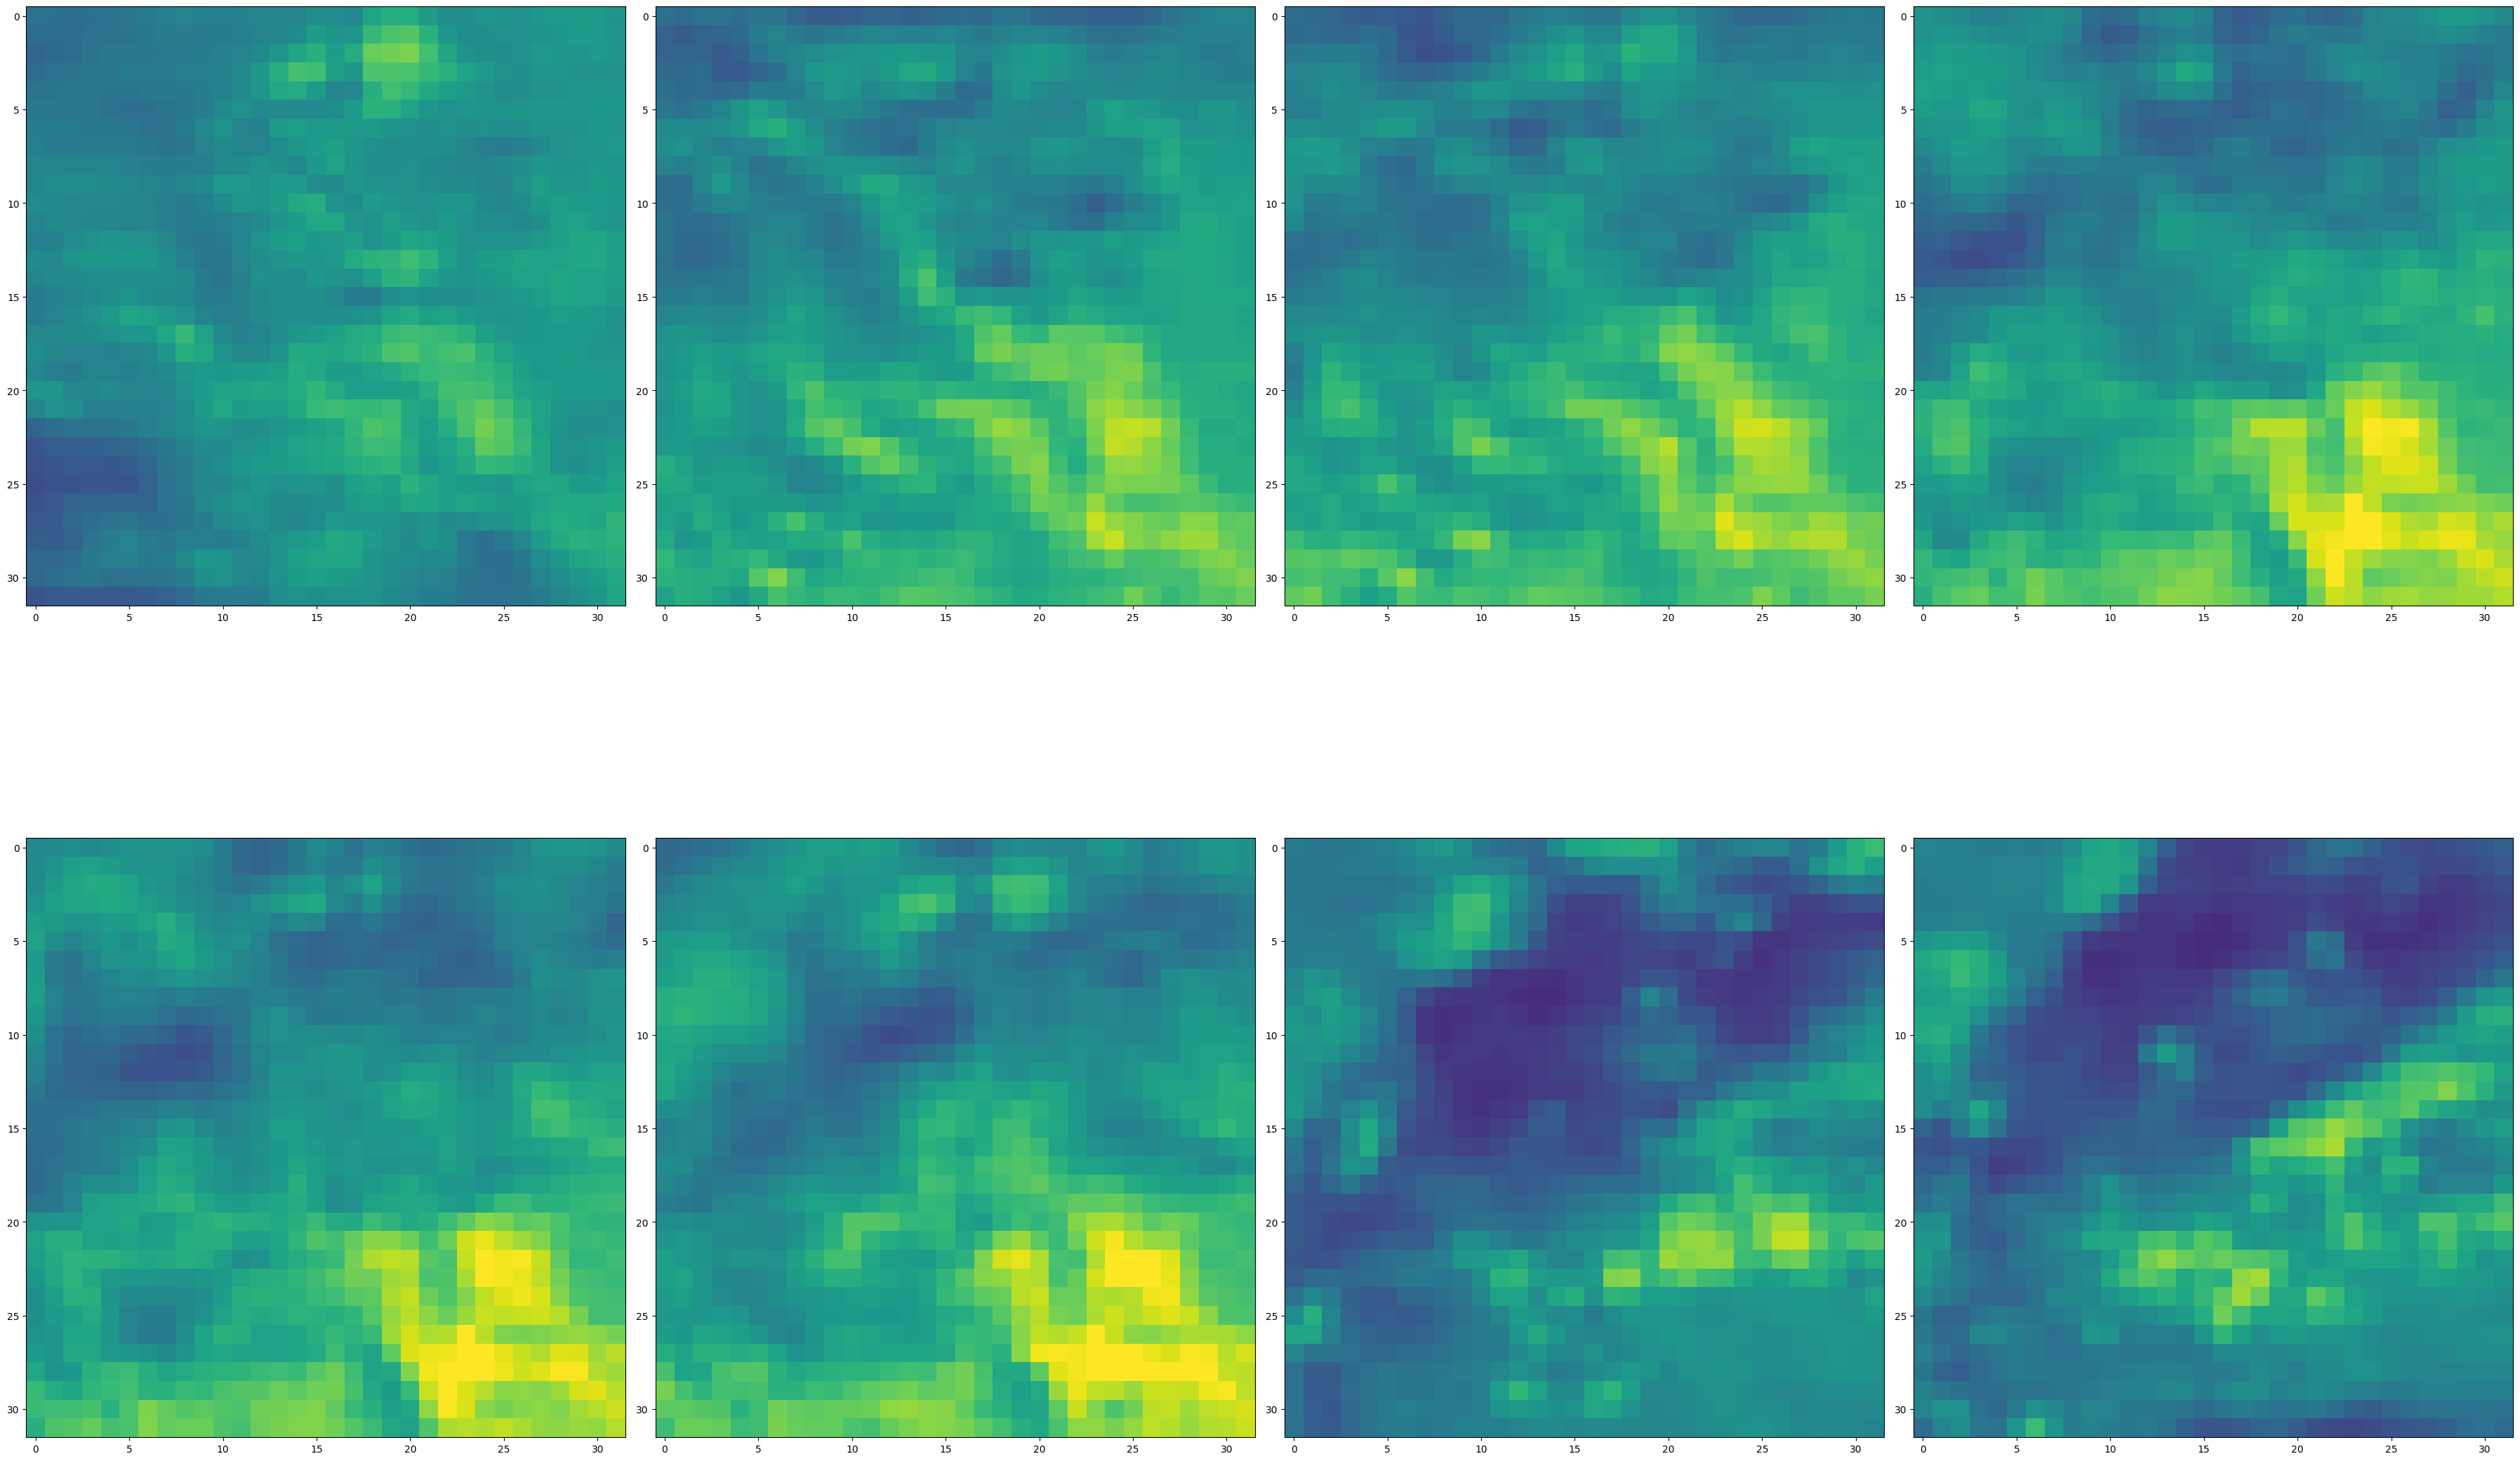

In [6]:
nrow = 2 # old data
ncol = 4

#nrow = 3
#ncol = 3

fig, axs = plt.subplots(nrow, ncol, figsize=(36, 27))

for i in range(nrow):
    for j in range(ncol):
        axs[i, j].imshow(channel7List[i* ncol + j], vmin=0, vmax=1) # vmin, vmax may change on different tiles
        #label = dfLabel.loc[dfLabel['fname'] == channel7Name[i* 6 + j], 'fire'].iloc[0]
        #axs[i, j].title.set_text('Label {}'.format(label))

plt.tight_layout()

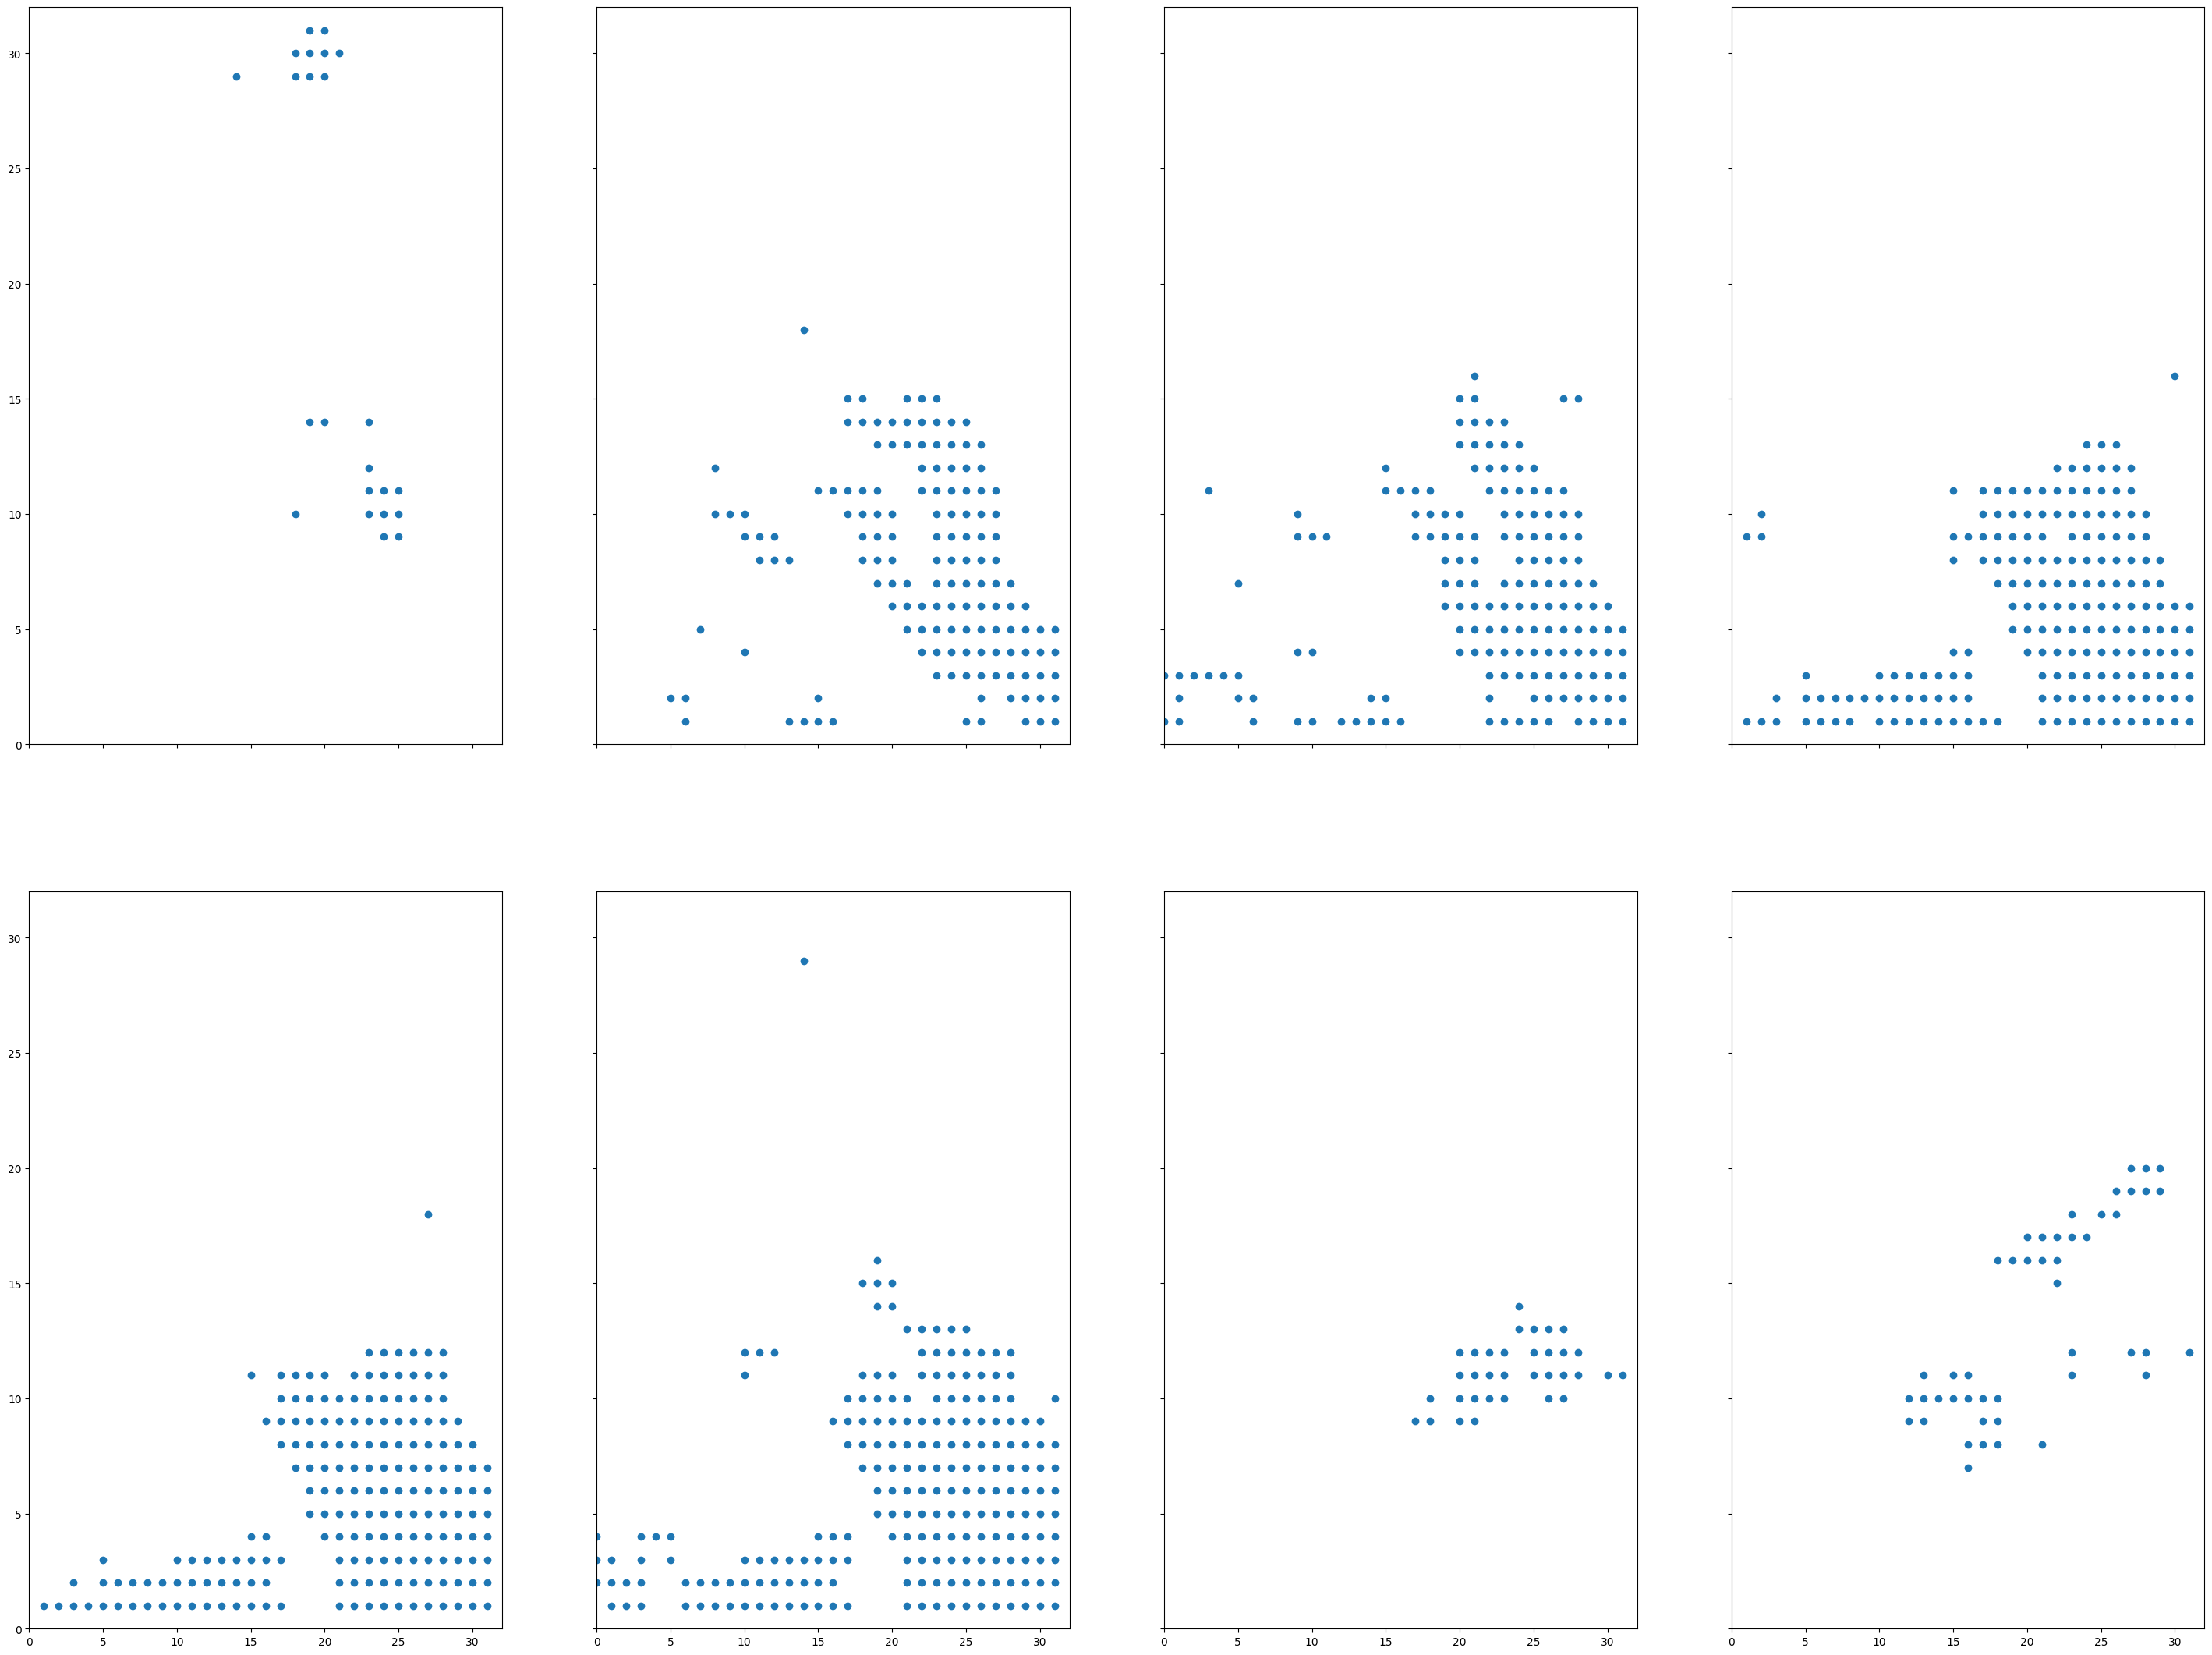

In [7]:
subLevel = 0.7

fig, ax = plt.subplots(nrow, ncol, sharex='col', sharey='row', figsize=(36, 27))
for i in range(0, nrow):
    for j in range(0, ncol):
        pointcloud = np.argwhere(np.array(channel7List[i*ncol + j]) > subLevel)
        x = pointcloud[:, 1]
        y = 32 - pointcloud[:, 0]
        ax[i, j].scatter(x, y)
        ax[i, j].set_xlim([0, 32])
        ax[i, j].set_ylim([0, 32])
plt.show()

In [8]:
def getAlphaExt(pointcloud): # pointcloud defined as list of points in R^2
    nodelst = pointcloud
    G = nx.Graph()
    G.add_edges_from( sp.cKDTree(nodelst).query_pairs(r=1) )

    groupList = []
    for x in nx.connected_components(G):
        groupList.append(list(x))

    regionDict = {}
    R_alpha_dict = {}
    shapeCount = 0
    for i in range(len(groupList)):
        regionDict['group{}'.format(i)] = np.array([nodelst[j] for j in groupList[i]])
        regionDict['group{}'.format(i)][:, 0] = 32 - regionDict['group{}'.format(i)][:, 0]

        if len(regionDict['group{}'.format(i)]) > 2: # change later to check collinearity
            alpha_shape = alphashape.alphashape(regionDict['group{}'.format(i)], 1) # set alpha = 1
            if alpha_shape.geom_type=='Polygon':
                xx, yy = alpha_shape.exterior.coords.xy
                R_alpha_dict['RAlpha{}'.format(shapeCount)] = list(zip(xx, yy))
                shapeCount += 1

            if alpha_shape.geom_type=='MultiPolygon':
                for ea in alpha_shape.geoms:
                    xx, yy = ea.exterior.coords.xy
                    R_alpha_dict['RAlpha{}'.format(shapeCount)] = list(zip(xx, yy))
                    shapeCount += 1

    P_alpha_list = []
    region_length_list = []
    for i in range(len(R_alpha_dict)):
        # print (len(list(set(R_alpha_dict['RAlpha{}'.format(i)]))))
        P_alpha_list = P_alpha_list + list(set(R_alpha_dict['RAlpha{}'.format(i)]))
        region_length_list.append(len(list(set(R_alpha_dict['RAlpha{}'.format(i)]))))
    P_alpha = np.array(P_alpha_list)

    return P_alpha.tolist(), region_length_list

In [9]:
def getAlphaShapeComplex(pointCloud, regionLengthList): #input R_alpha
    points = [i for i in range(len(pointCloud))]
    tempLengthList = [0] + regionLengthList
    stamp = np.cumsum(tempLengthList)

    tempDict = {}
    simpDict = {}
    for i in range(len(tempLengthList) - 1):
        tempDict['region{}'.format(i)] = points[stamp[i]:stamp[i+1]]
        tempDict['region{}'.format(i)].append(tempDict['region{}'.format(i)][0])

        simpDict['region{}_simp'.format(i)] = []
        for j in range(len(tempDict['region{}'.format(i)])):
            #simpDict['region{}_simp'.format(i)].append([tempDict['region{}'.format(i)][j]])
            if j != len(tempDict['region{}'.format(i)]) - 1:
                simpDict['region{}_simp'.format(i)].append([tempDict['region{}'.format(i)][j]])
                simpDict['region{}_simp'.format(i)].append([tempDict['region{}'.format(i)][j], tempDict['region{}'.format(i)][j+1]])

    f = d.Filtration()
    for i in range(len(simpDict)):
        for vertices in simpDict['region{}_simp'.format(i)]:
            f.append(d.Simplex(vertices))

    return f

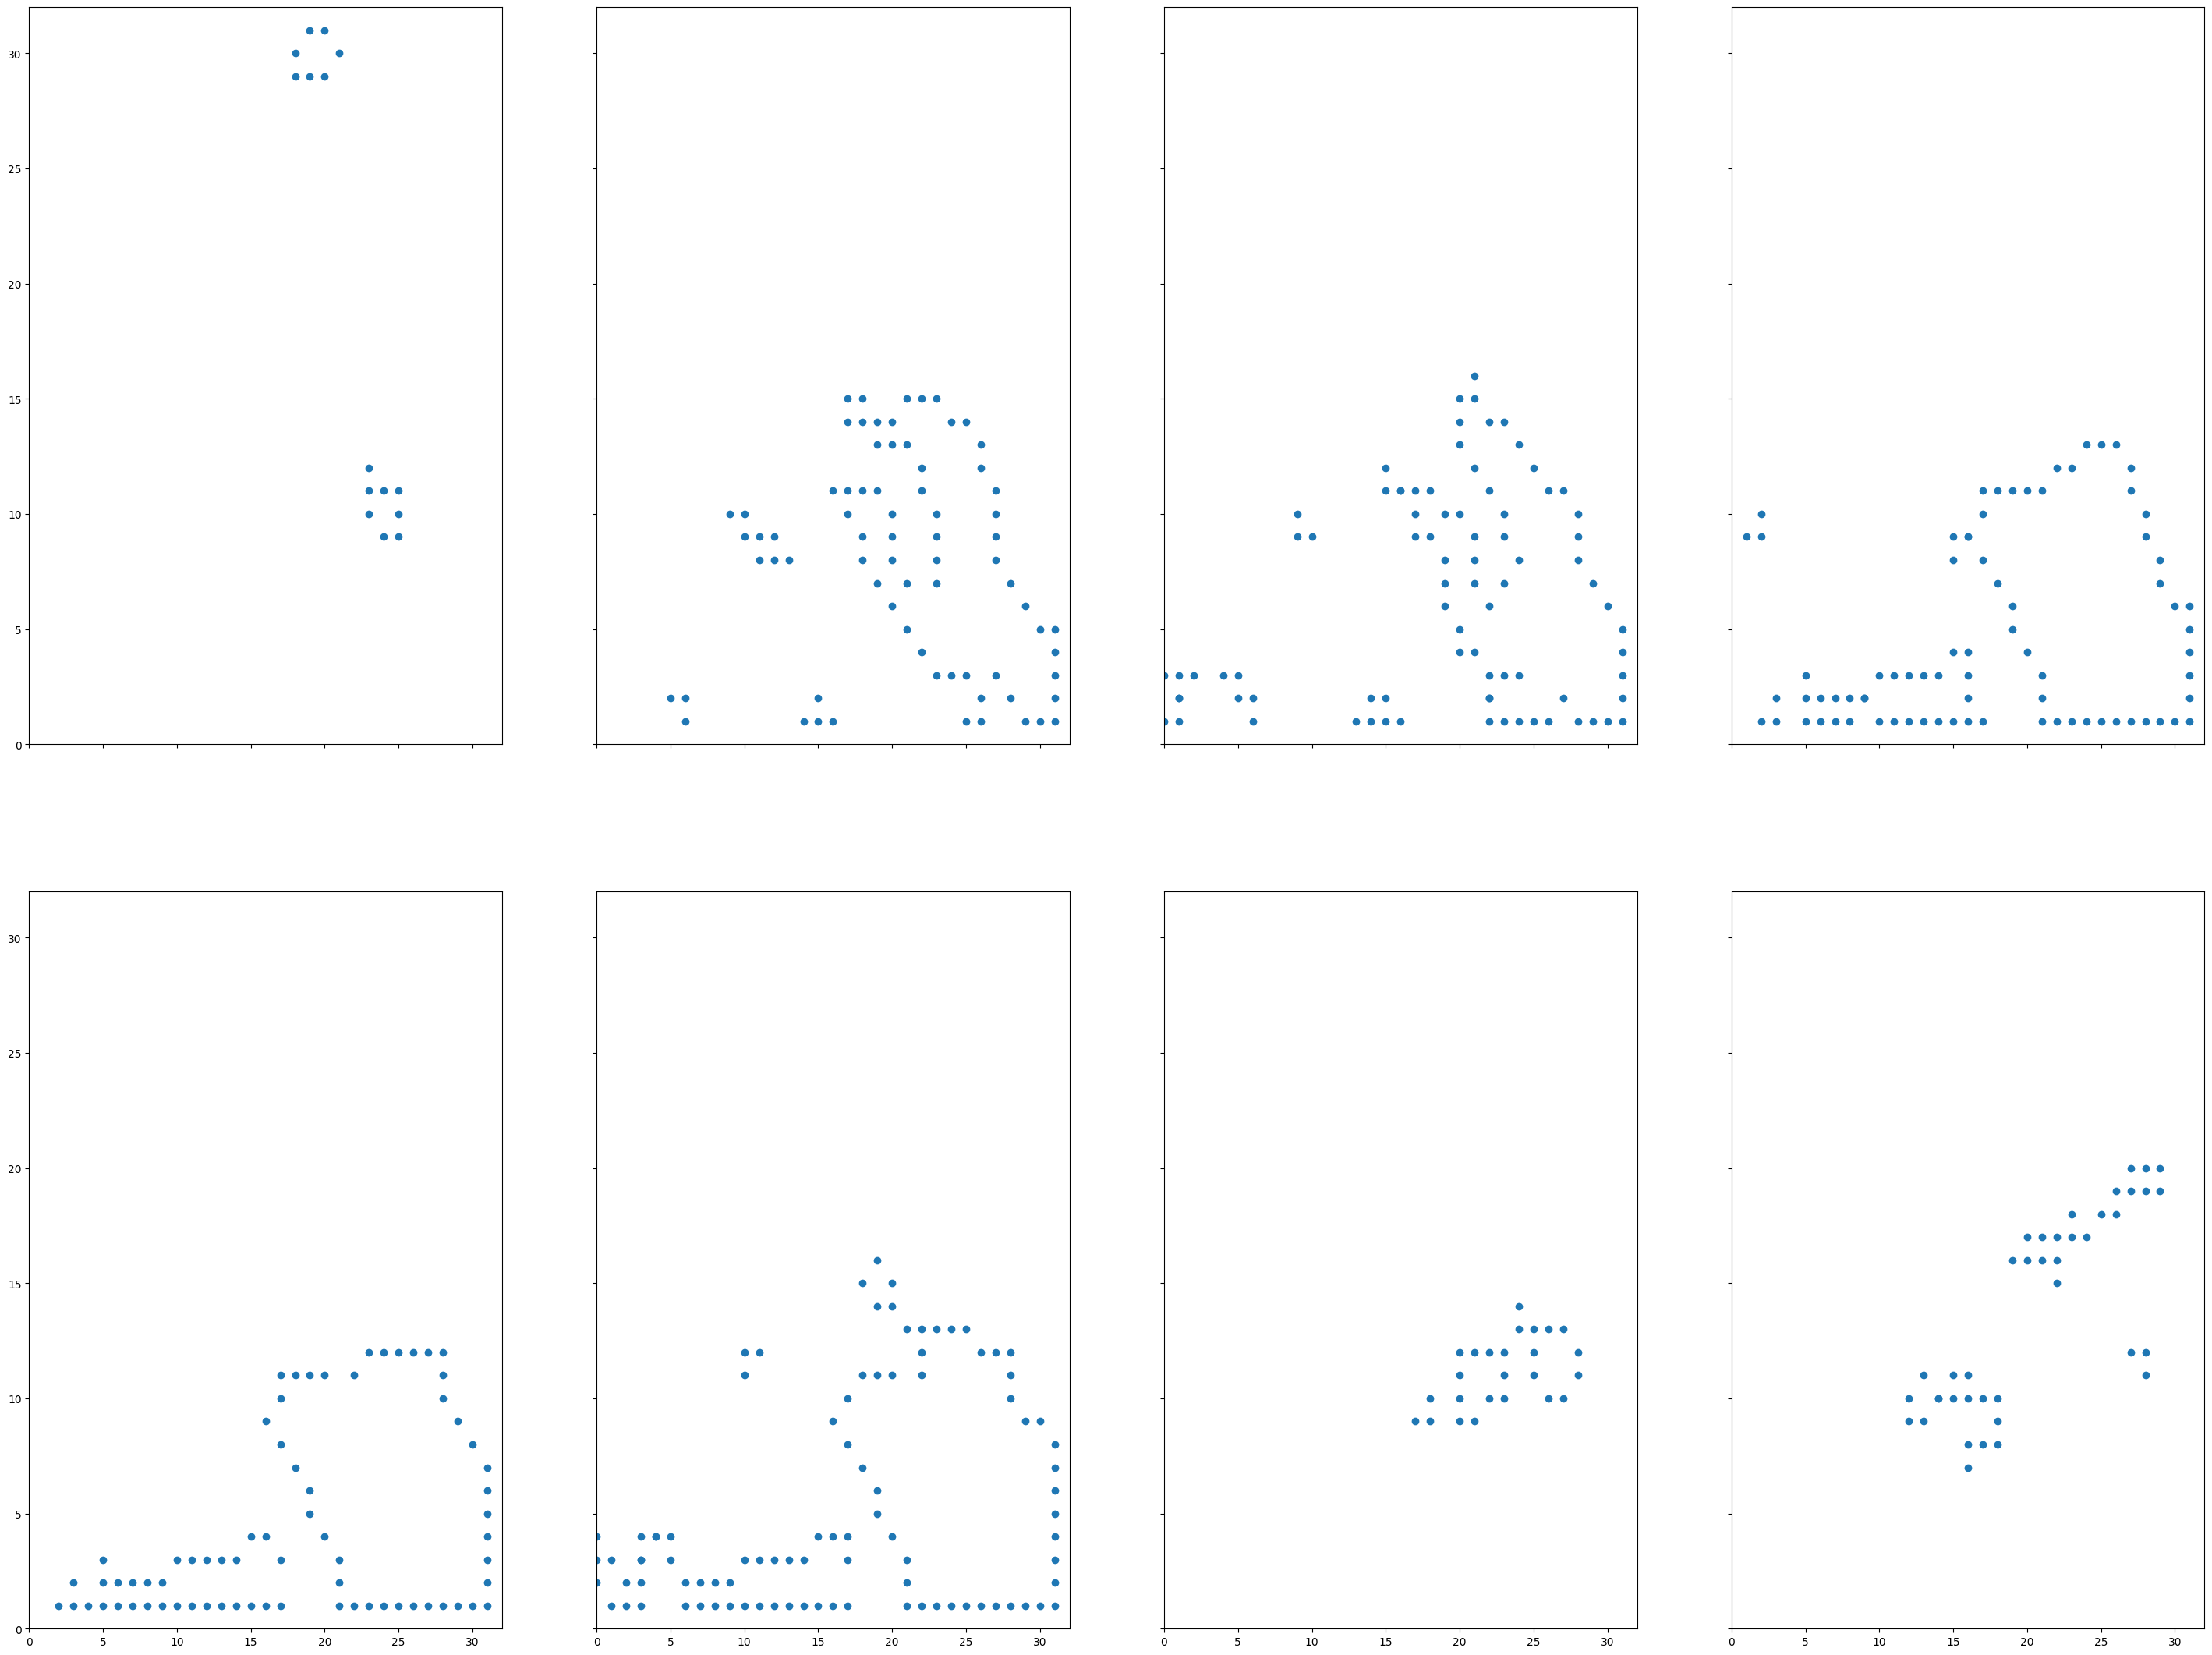

In [10]:
fig, ax = plt.subplots(nrow, ncol, sharex='col', sharey='row', figsize=(36, 27))

zigzagDataList = []
regionLengthList = []
for i in range(0, nrow):
    for j in range(0, ncol):
        pointcloud = np.argwhere(np.array(channel7List[i*ncol + j]) > subLevel)
        P_alpha_list, region_length = getAlphaExt(pointcloud)
        newPtCld = np.array(P_alpha_list)
        if newPtCld.size == 0:
            x = [0]
            y = [0]
            newPtCld = np.array([[0, 0]])
        else:
            x = newPtCld[:, 1]
            y = newPtCld[:, 0]

        zigzagDataList.append(newPtCld)
        regionLengthList.append(region_length)
        ax[i, j].scatter(x, y)
        ax[i, j].set_xlim([0, 32])
        ax[i, j].set_ylim([0, 32])

plt.show()

In [11]:
print (len(zigzagDataList))

8


In [12]:
def shift_filtration(rips,n):
    "Take a Dionysus filtration and increase the name of all of the vertices by n."
    f = d.Filtration()
    for s in rips:
        dim = s.dimension()
        temp = []
        for i in range(0,dim+1):
            temp.append(s[i]+n)
        f.append(d.Simplex(temp,s.data))
    return f

def get_verts(simp):
    if simp.dimension == 2:
        return [d.Simplex([v], 0) for v in t]
    else:
        return set([s for s in simp.boundary()])

tempPtCldLengthList = []
for i in zigzagDataList:
    tempPtCldLengthList.append(len(i))
ptCldLengthList = np.cumsum(tempPtCldLengthList).tolist()
ptCldLengthList.insert(0, 0)
ptCldLengthList = np.array(ptCldLengthList)

def setup_Zigzag_fixed(lst, r, verbose=False):

    simps_list = []
    times_list = []

    # Initialize A with R(X_0)
    rips = d.fill_rips(lst[0].astype(np.float32), 2, r)
    # rips = getAlphaShapeComplex(lst[0], regionLengthList[0])
    for s in rips:
        s.data = 0.0
    rips.sort()
    rips_set = set(rips)

    # Initialize A with set of simplices with verts in X_0
    A = rips_set

    # # Add all simps to the list with birth,death=[0,1]
    simps_list = simps_list + [s for s in A]
    times_list = times_list + [[0, 1] for j in range(len(A))]

    for i in range(1, len(lst)):
        print ('Working on number {}'.format(i))
        # Calculate rips of X_{i-1} \cup X_i

        rips = d.fill_rips(np.vstack([lst[i-1], lst[i]]).astype(np.float32), 2, r)
        rips = shift_filtration(rips, ptCldLengthList[i-1])
        for s in rips:
            s.data = 0.0

        # Set of vertices in R(X_i)
        # B = getAlphaShapeComplex(lst[i], regionLengthList[i])
        B = d.fill_rips(lst[i].astype(np.float32), 2, r)
        B = shift_filtration(B, ptCldLengthList[i])
        for s in B:
            s.data = 0.0

        # Set of simplices with verts in X_{i-1} AND X_{i}
        M = set()

        # Loop over vertices in R(X_{i-1} \cup R_i)
        for simp in rips:

            # Get list of vertices of simp
            bdy = get_verts(simp)
            #print ('simp: {}'.format(simp))
            #print ('body:{}'.format(bdy))
            #print ('Simplex {} has vertices {}'.format(simp, bdy))
            # If it has no boundary and its in B, its a vertex in B and has been handled
            if simp in A:
                continue

            elif simp in B:
                continue

            else:
                #if simp not in simps_list:
                M.add(simp)

        # Add simplices in B with the corresponding birth,death times
        simps_list = simps_list + [s for s in B]
        times_list = times_list + [[i-0.5, i+1] for j in range(len(B))]

        # Add simplicies in M with corresponding birth,death times
        simps_list = simps_list + [s for s in M]
        times_list = times_list + [[i-0.5, i] for j in range(len(M))]

        # Reinitialize for next iteration
        A = B

    filtration = d.Filtration(simps_list)

    print ('length of time list: {}'.format(len(times_list)))
    print ('length of simp list: {}'.format(len(simps_list)))
    print ('length of filtration: {}'.format(len(filtration)))

    return filtration, times_list

In [13]:
filtration, times_list = setup_Zigzag_fixed(zigzagDataList, 4)
#zz, dgms, cells = d.zigzag_homology_persistence(filtration, times_list)

Working on number 1
Working on number 2
Working on number 3
Working on number 4
Working on number 5
Working on number 6
Working on number 7
length of time list: 38360
length of simp list: 38360
length of filtration: 38360


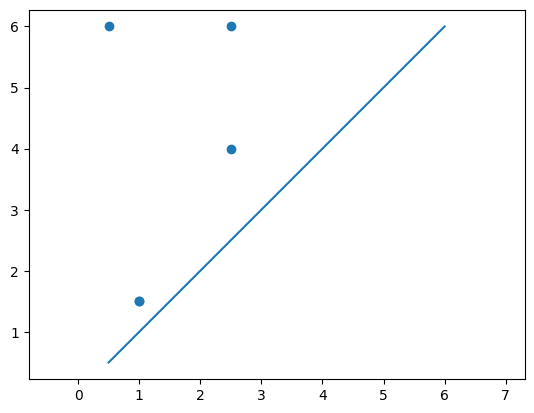

In [14]:
#d.plot.plot_diagram(dgms[0], show = True)
zz, dgms, cells = d.zigzag_homology_persistence(filtration, times_list)
d.plot.plot_diagram(dgms[1], show = True)